Чтобы иметь возможность отправлять отчетность в корпоративный мессенджер, в нашем случае - телеграм, создадим своего телеграм-бота с помощью @BotFather. Для этого:
- импортируем нужную библиотеку
- передадим токен, полученный от botfather при создании бота

In [1]:
import telegram
import pandas as pd

Проичитаем token из файла token_telegram_bot и запишем его в переменную token

In [2]:
with open('token_telegram_bot.txt', 'r+') as f:
    token = f.read()

In [3]:
bot = telegram.Bot(token=token)

Чтобы бот мог вести с напи переписку его нужно запустить (начать с ним диалог через start или что-то ему написать). Отправим сообщение себе в личку. Для этого предварительно узнаем свой chat_id

In [4]:
updates = bot.getUpdates()
print(updates[-1])

{'update_id': 393399505, 'message': {'photo': [], 'new_chat_members': [], 'date': 1639942910, 'delete_chat_photo': False, 'entities': [{'length': 6, 'type': 'bot_command', 'offset': 0}], 'text': '/start', 'new_chat_photo': [], 'message_id': 804, 'channel_chat_created': False, 'group_chat_created': False, 'caption_entities': [], 'supergroup_chat_created': False, 'chat': {'last_name': 'Кульминский', 'username': 'wkylminskii', 'id': 484756871, 'type': 'private', 'first_name': 'Вячеслав'}, 'from': {'is_bot': False, 'username': 'wkylminskii', 'id': 484756871, 'first_name': 'Вячеслав', 'language_code': 'ru', 'last_name': 'Кульминский'}}}


In [4]:
chat_id = 484756871

Научимся отправлять файлы. Достанем данные из базы (небольшые датафреймы) и отправим их себе. Для этого импортируем коннектор Getch из папки read_db

In [5]:
from read_db.CH import Getch

Получим число уникальных юзеров, которые пользуются как лентой так и мессенджером за предыдущий день и до текущего момента, округленного к ближайшей 15-ти минутке

In [12]:
data = Getch(
'''
select
    toStartOfInterval(time, INTERVAL 15 minute) as interval,
    count(distinct user_id) as count_unique
from simulator.feed_actions
inner join simulator.message_actions on simulator.feed_actions.user_id = simulator.message_actions.user_id
where interval >= today() - 1 and interval < toStartOfInterval(now(), INTERVAL 15 minute)
group by interval
order by interval
'''
).df
data.head()

interval  count_unique
0 2022-01-11 00:00:00           275
1 2022-01-11 00:15:00           270
2 2022-01-11 00:30:00           265
3 2022-01-11 00:45:00           253
4 2022-01-11 01:00:00           218

In [13]:
data.shape

(150, 2)

Изобразим результат

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

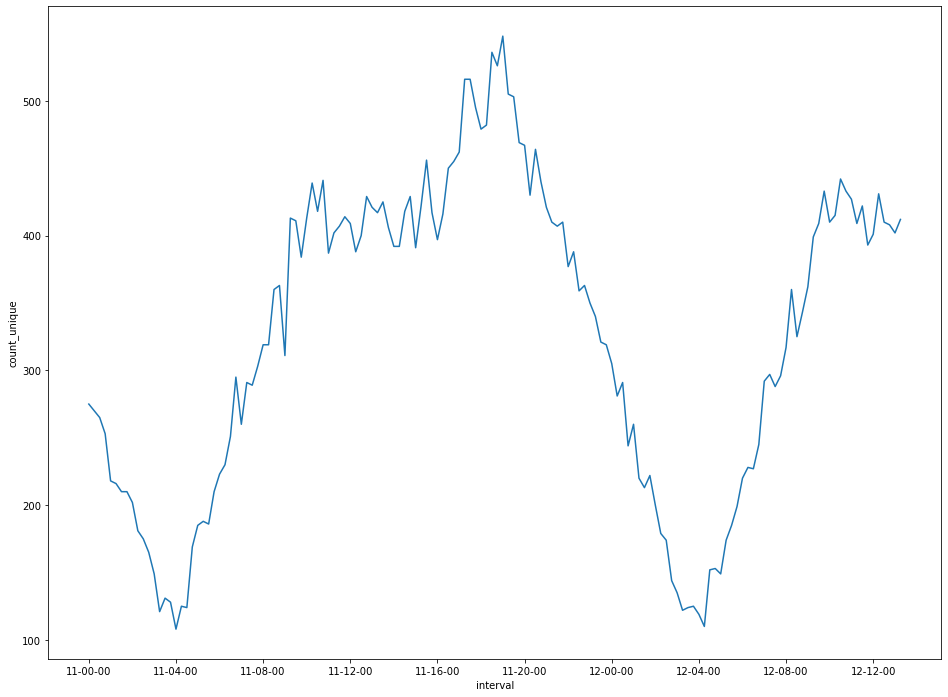

In [15]:
plt.figure(figsize=(16,12))
myFmt = mdates.DateFormatter('%d-%H-%M')

ax = sns.lineplot(data=data, x='interval', y='count_unique')
ax.xaxis.set_major_formatter(myFmt)

Рассчитаем уровни отклонения от полученных выше значений, при пробое которых в систему отправляется предупреждение

In [16]:
data['level_1'] = data.count_unique.rolling(window=15, min_periods=1, closed='left').mean() - data.count_unique.std()*1

In [17]:
data['level_2'] = data.count_unique.rolling(window=15, min_periods=1, closed='left').mean() + data.count_unique.std()*1

In [18]:
data.count_unique.std()

116.736998423357

In [19]:
data

interval  count_unique     level_1     level_2
0   2022-01-11 00:00:00           275         NaN         NaN
1   2022-01-11 00:15:00           270  158.263002  391.736998
2   2022-01-11 00:30:00           265  155.763002  389.236998
3   2022-01-11 00:45:00           253  153.263002  386.736998
4   2022-01-11 01:00:00           218  149.013002  382.486998
..                  ...           ...         ...         ...
145 2022-01-12 12:15:00           431  284.796335  518.270332
146 2022-01-12 12:30:00           410  291.863002  525.336998
147 2022-01-12 12:45:00           408  296.329668  529.803665
148 2022-01-12 13:00:00           402  299.396335  532.870332
149 2022-01-12 13:15:00           412  299.596335  533.070332

[150 rows x 4 columns]

In [20]:
data.index.max()

149

In [21]:
data.count_unique[data.index.max()]

412

In [22]:
data.level_2[data.index.max()]

533.0703317566903

In [23]:
data.level_1[data.index.max()]

299.59633490997635

In [24]:
data.interval[data.index.max()]

Timestamp('2022-01-12 13:15:00')

Метрика: кол-во уникальных пользователей в срезе 2022-01-12 13:15:00  
Текущее значение: 412

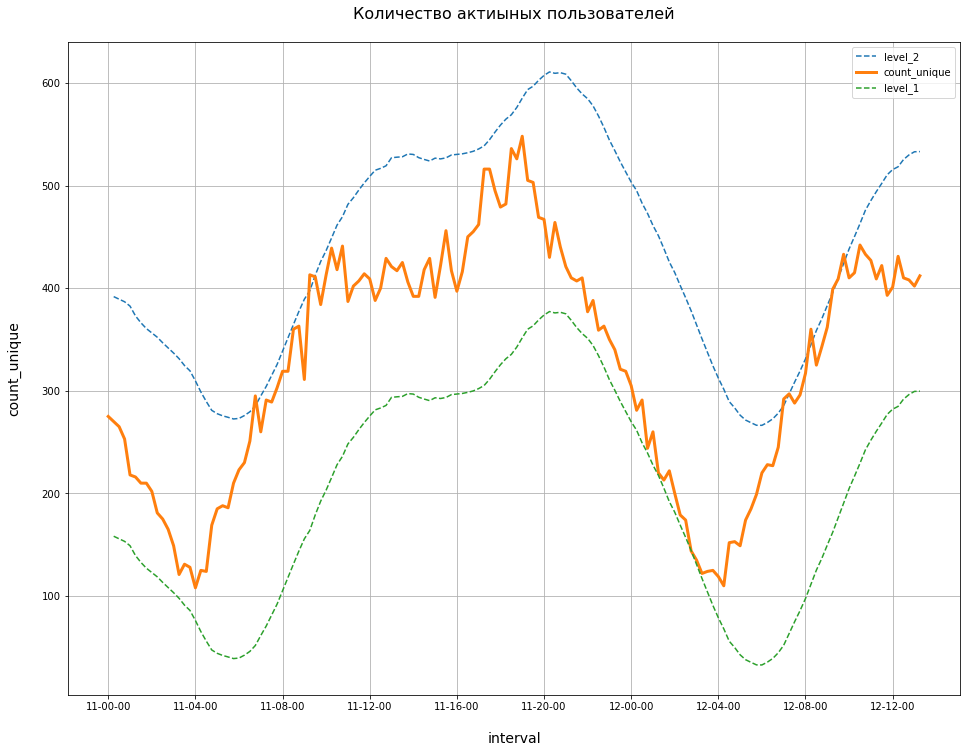

In [26]:
plt.figure(figsize=(16,12))
myFmt = mdates.DateFormatter('%d-%H-%M')

axes = plt.gca()

sns.lineplot(data=data, x='interval', y='level_2', label='level_2', linestyle='--')
sns.lineplot(data=data, x='interval', y='count_unique', label='count_unique', linewidth=3.0)
sns.lineplot(data=data, x='interval', y='level_1', label='level_1', linestyle='--')

axes.set_title('Количество актиыных пользователей\n', fontsize=16)
axes.xaxis.set_major_formatter(myFmt)

plt.xlabel('\ninterval', fontsize=14)
plt.ylabel('count_unique\n', fontsize=14)
plt.grid(True);

In [28]:
link_chart = 'http://superset.lab.karpov.courses/r/241'
link_dashboard = 'http://superset.lab.karpov.courses/r/236'
gap = data.count_unique[data.index.max()]

В случае пробоя отправим в чат текстовое сообщение и график

In [30]:
if data.count_unique[data.index.max()] > data.level_2[data.index.max()]:
    dev = (gap / data.level_2[data.index.max()] - 1)
    
    msg = f'Метрика: кол-во уникальных пользователей в срезе {data.interval[data.index.max()]}:\n\
    Текущее значение: {gap}\n\
    Отклонение: {dev:.0%}\n\
    Чарт метрики: {link_chart}\n\
    Дашборд: {link_dashboard}'

    bot.sendMessage(chat_id=chat_id, text=msg)
    
elif data.count_unique[data.index.max()] < data.level_1[data.index.max()]:
    dev = (gap / data.level_1[data.index.max()] - 1)

    msg = f'Метрика: кол-во уникальных пользователей в срезе {data.interval[data.index.max()]}:\n\
    Текущее значение: {gap}\n\
    Отклонение: {dev:.0%}\n\
    Чарт метрики: {link_chart}\n\
    Дашборд: {link_dashboard}'

    bot.sendMessage(chat_id=chat_id, text=msg)

if data.count_unique[data.index.max()] > data.level_2[data.index.max()] or\
   data.count_unique[data.index.max()] < data.level_1[data.index.max()]:
    
    # задаем размер графика
    plt.figure(figsize=(16,12))
    # форматируем дату
    myFmt = mdates.DateFormatter('%d-%H-%M')
    # создаем ось
    axes = plt.gca()

    sns.lineplot(data=data, x='interval', y='level_2', label='level_2', linestyle='--')
    sns.lineplot(data=data, x='interval', y='count_unique', label='count_unique', linewidth=3.0)
    sns.lineplot(data=data, x='interval', y='level_1', label='level_1', linestyle='--')

    axes.set_title('Количество актиыных пользователей\n', fontsize=16)
    axes.xaxis.set_major_formatter(myFmt)

    plt.xlabel('\ninterval', fontsize=14)
    plt.ylabel('count_unique\n', fontsize=14)
    plt.grid(True);

    import io # позволяет перенаправлять потоки ввода вывода данных, тем самым мы сохраним график не как 
    # файл в вайловой системе, а как файловый объект в буфере и соответственно будем доставать его из буфера

    # зададим файловый объект
    plot_object = io.BytesIO()
    # сохраним в него наш график
    plt.savefig(plot_object)
    # зададим имя нашему файловому объекту
    plot_object.name = 'alert_plot.png'
    # перенесем курсор из конца файлового объекта в начало, чтобы прочитать весь файл
    plot_object.seek(0)
    # закроем файл
    plt.close()
    # отправим изображение
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)

Сделаме тоже самое для CTR

In [29]:
data_ctr = Getch(
'''
select 
    toStartOfInterval(time, INTERVAL 15 minute) as interval,
    countIf(user_id, action='like') / countIf(user_id, action='view') as CTR
from simulator.feed_actions
where interval >= today() - 1 and interval < toStartOfInterval(now(), INTERVAL 15 minute)
group by interval
order by interval
'''
).df
data_ctr.head()

interval       CTR
0 2022-01-11 00:00:00  0.225565
1 2022-01-11 00:15:00  0.223055
2 2022-01-11 00:30:00  0.229137
3 2022-01-11 00:45:00  0.224756
4 2022-01-11 01:00:00  0.214959

In [30]:
data_ctr.shape

(150, 2)

Изобразим результат

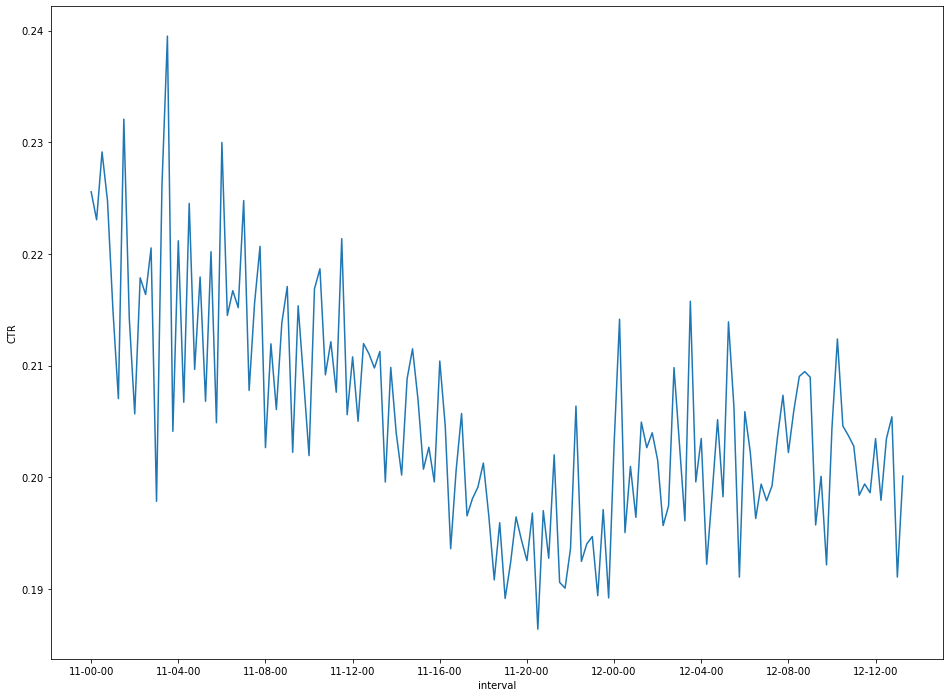

In [31]:
plt.figure(figsize=(16,12))
myFmt = mdates.DateFormatter('%d-%H-%M')

ax = sns.lineplot(data=data_ctr, x='interval', y='CTR')
ax.xaxis.set_major_formatter(myFmt);

Рассчитаем уровни отклонения от полученных выше значений, при пробое которых в систему должно подаваться предупреждение

In [32]:
data_ctr['level_1'] = data_ctr.CTR.rolling(window=7, min_periods=1, closed='left').mean() - data_ctr.CTR.std()*1.2

In [33]:
data_ctr['level_2'] = data_ctr.CTR.rolling(window=7, min_periods=1, closed='left').mean() + data_ctr.CTR.std()*1.2

In [34]:
data_ctr.CTR.std()

0.009999772023797565

In [35]:
data_ctr

interval       CTR   level_1   level_2
0   2022-01-11 00:00:00  0.225565       NaN       NaN
1   2022-01-11 00:15:00  0.223055  0.213565  0.237565
2   2022-01-11 00:30:00  0.229137  0.212311  0.236310
3   2022-01-11 00:45:00  0.224756  0.213919  0.237919
4   2022-01-11 01:00:00  0.214959  0.213629  0.237628
..                  ...       ...       ...       ...
145 2022-01-12 12:15:00  0.197926  0.189562  0.213562
146 2022-01-12 12:30:00  0.203462  0.188612  0.212612
147 2022-01-12 12:45:00  0.205410  0.188572  0.212572
148 2022-01-12 13:00:00  0.191053  0.188948  0.212947
149 2022-01-12 13:15:00  0.200094  0.187901  0.211900

[150 rows x 4 columns]

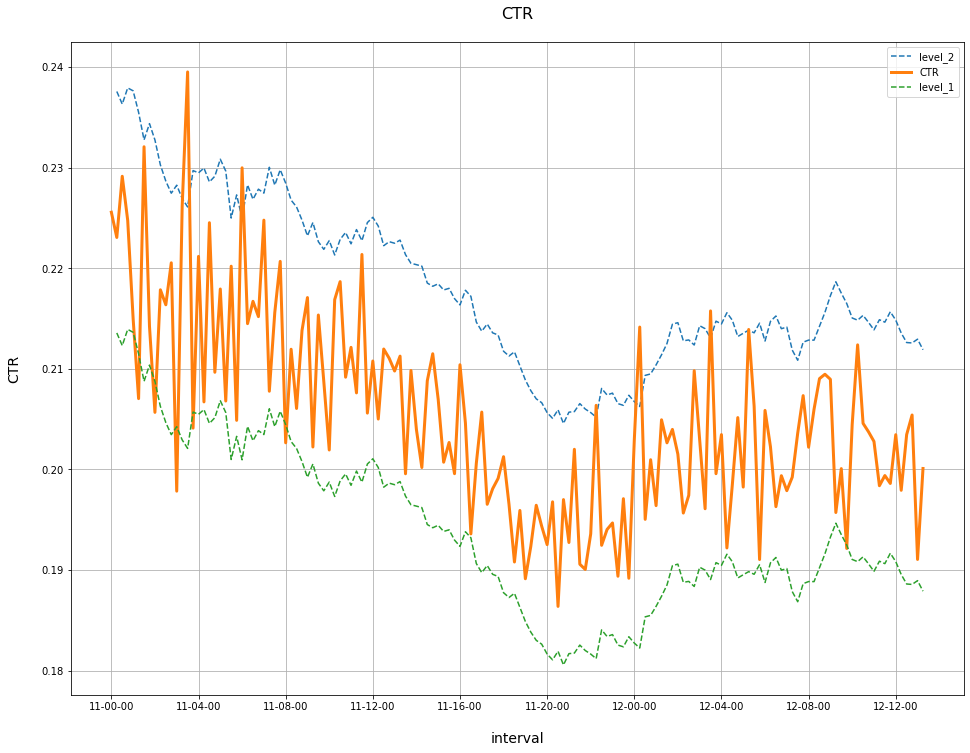

In [36]:
plt.figure(figsize=(16,12))
myFmt = mdates.DateFormatter('%d-%H-%M')
axes = plt.gca()

sns.lineplot(data=data_ctr, x='interval', y='level_2', label='level_2', linestyle='--')
sns.lineplot(data=data_ctr, x='interval', y='CTR', label='CTR', linewidth=3.0)
sns.lineplot(data=data_ctr, x='interval', y='level_1', label='level_1', linestyle='--')

axes.set_title('CTR\n', fontsize=16)
axes.xaxis.set_major_formatter(myFmt)

plt.xlabel('\ninterval', fontsize=14)
plt.ylabel('CTR\n', fontsize=14)
plt.grid(True);

In [37]:
link_chart_ctr = 'http://superset.lab.karpov.courses/r/240'
link_dashboard_ctr = 'http://superset.lab.karpov.courses/r/239'
gap_ctr = data_ctr.CTR[data_ctr.index.max()]

В случае пробоя отправим текстовое сообщение и график в чат

In [40]:
if data_ctr.CTR[data_ctr.index.max()] > data_ctr.level_2[data_ctr.index.max()]:    
    dev_ctr = (gap_ctr / data_ctr.level_2[data_ctr.index.max()] - 1)
    
    msg_ctr = f'Метрика: CTR в срезе {data_ctr.interval[data_ctr.index.max()]}:\n\
    Текущее значение: {round(gap_ctr, 2)}\n\
    Отклонение: {dev_ctr:.1%}\n\
    Чарт метрики: {link_chart_ctr}\n\
    Дашборд: {link_dashboard_ctr}'

    bot.sendMessage(chat_id=chat_id, text=msg_ctr)
    
elif data_ctr.CTR[data_ctr.index.max()] < data_ctr.level_1[data_ctr.index.max()]:
    dev_ctr = (gap_ctr / data_ctr.level_1[data_ctr.index.max()] - 1)

    msg_ctr = f'Метрика: CTR в срезе {data_ctr.interval[data_ctr.index.max()]}:\n\
    Текущее значение: {round(gap_ctr, 2)}\n\
    Отклонение: {dev_ctr:.1%}\n\
    Чарт метрики: {link_chart_ctr}\n\
    Дашборд: {link_dashboard_ctr}'

    bot.sendMessage(chat_id=chat_id, text=msg_ctr)
    
if data_ctr.CTR[data_ctr.index.max()] > data_ctr.level_2[data_ctr.index.max()] or\
   data_ctr.CTR[data_ctr.index.max()] < data_ctr.level_1[data_ctr.index.max()]:

    plt.figure(figsize=(16,12))
    myFmt = mdates.DateFormatter('%d-%H-%M')
    axes = plt.gca()

    sns.lineplot(data=data_ctr, x='interval', y='level_2', label='level_2', linestyle='--')
    sns.lineplot(data=data_ctr, x='interval', y='CTR', label='CTR', linewidth=3.0)
    sns.lineplot(data=data_ctr, x='interval', y='level_1', label='level_1', linestyle='--')

    axes.set_title('CTR\n', fontsize=16)
    axes.xaxis.set_major_formatter(myFmt)

    plt.xlabel('\ninterval', fontsize=14)
    plt.ylabel('CTR\n', fontsize=14)
    plt.grid(True);

    import io 

    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.name = 'alert_plot.png'
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)

Сделаем тоже самое для отправленных сообщений

In [38]:
data_message = Getch(
'''
select 
    toStartOfInterval(time, INTERVAL 15 minute) as interval,
    count(user_id) as count_message
from simulator.message_actions
where interval >= today() - 1 and interval < toStartOfInterval(now(), INTERVAL 15 minute)
group by interval
order by interval
'''
).df
data_message.head()

interval  count_message
0 2022-01-11 00:00:00             75
1 2022-01-11 00:15:00             81
2 2022-01-11 00:30:00             79
3 2022-01-11 00:45:00             72
4 2022-01-11 01:00:00             71

In [39]:
data_message.shape

(150, 2)

Отобразим результат

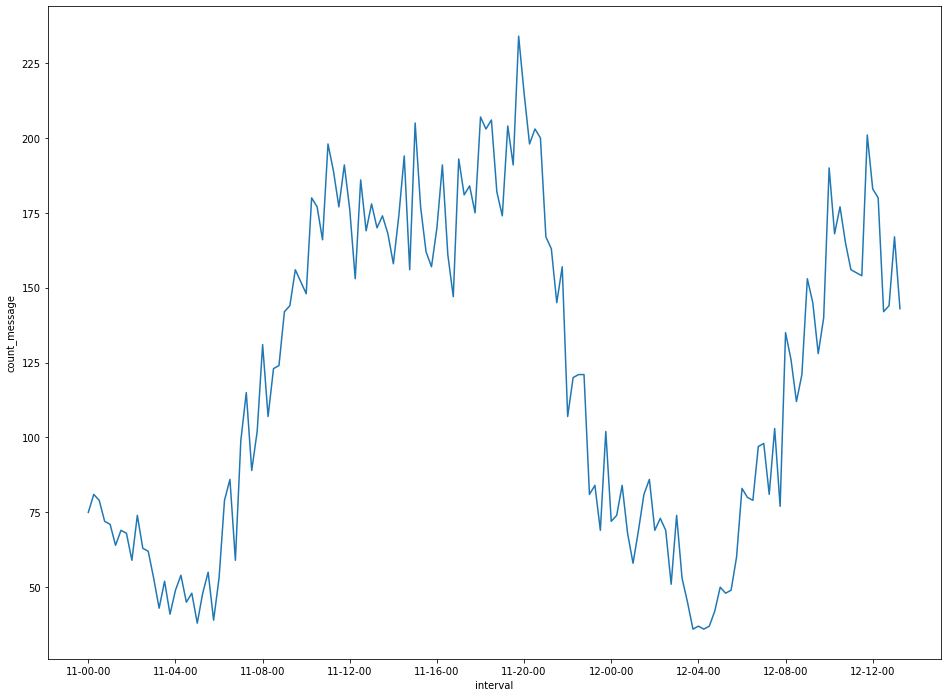

In [40]:
plt.figure(figsize=(16,12))
myFmt = mdates.DateFormatter('%d-%H-%M')

ax = sns.lineplot(data=data_message, x='interval', y='count_message')
ax.xaxis.set_major_formatter(myFmt);

Рассчитаем уровни отклонения от полученных выше значений, при пробое которых в систему должно подаваться предупреждение

In [41]:
data_message['level_1'] = data_message.count_message.rolling(window=10, min_periods=1, closed='left').mean()\
                        - data_message.count_message.std()*1.2

In [42]:
data_message['level_2'] = data_message.count_message.rolling(window=10, min_periods=1, closed='left').mean()\
                        + data_message.count_message.std()*1.2

In [43]:
data_message.count_message.std()

54.824741716222974

In [44]:
data_message

interval  count_message     level_1     level_2
0   2022-01-11 00:00:00             75         NaN         NaN
1   2022-01-11 00:15:00             81    9.210310  140.789690
2   2022-01-11 00:30:00             79   12.210310  143.789690
3   2022-01-11 00:45:00             72   12.543643  144.123023
4   2022-01-11 01:00:00             71   10.960310  142.539690
..                  ...            ...         ...         ...
145 2022-01-12 12:15:00            180  103.110310  234.689690
146 2022-01-12 12:30:00            142  107.110310  238.689690
147 2022-01-12 12:45:00            144  102.310310  233.889690
148 2022-01-12 13:00:00            167   99.910310  231.489690
149 2022-01-12 13:15:00            143   98.910310  230.489690

[150 rows x 4 columns]

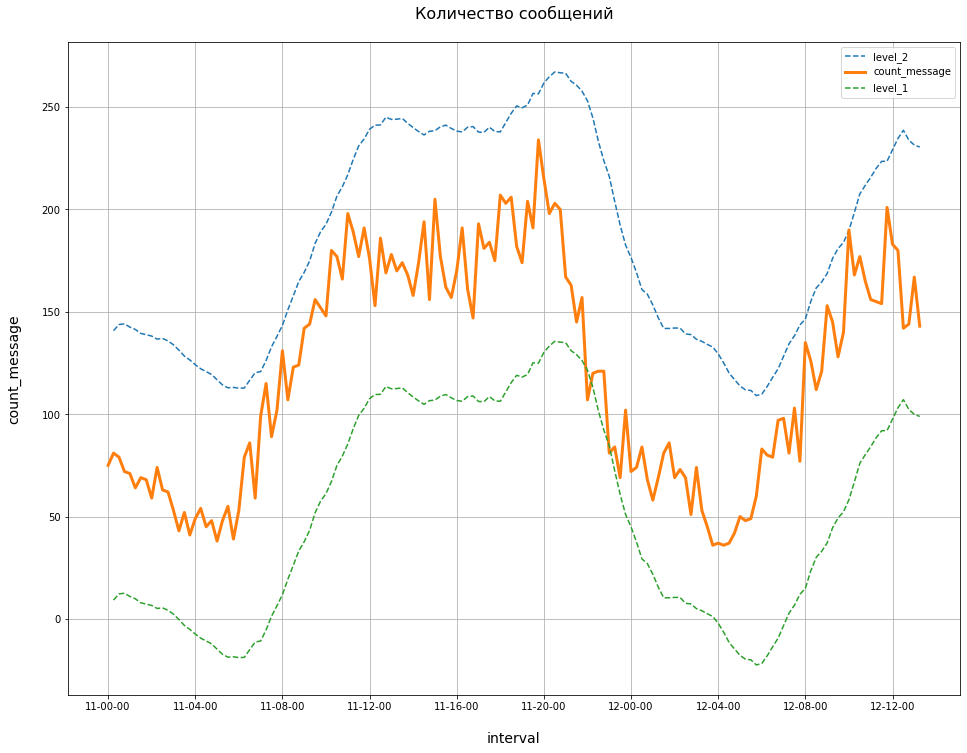

In [45]:
plt.figure(figsize=(16,12))
myFmt = mdates.DateFormatter('%d-%H-%M')
axes = plt.gca()

sns.lineplot(data=data_message, x='interval', y='level_2', label='level_2', linestyle='--')
sns.lineplot(data=data_message, x='interval', y='count_message', label='count_message', linewidth=3.0)
sns.lineplot(data=data_message, x='interval', y='level_1', label='level_1', linestyle='--')

axes.set_title('Количество сообщений\n', fontsize=16)
axes.xaxis.set_major_formatter(myFmt)

plt.xlabel('\ninterval', fontsize=14)
plt.ylabel('count_message\n', fontsize=14)
plt.grid(True);

In [46]:
link_chart_message = 'http://superset.lab.karpov.courses/r/243'
link_dashboard_message = 'http://superset.lab.karpov.courses/r/242'
gap_message = data_message.count_message[data_message.index.max()]

В случае пробоя отправим текстовое сообщение и график в чат

In [50]:
try:
    if data_message.count_message[data_message.index.max()] > data_message.level_2[data_message.index.max()]:    
        dev_message = (gap_message / data_message.level_2[data_message.index.max()] - 1)

        msg_message = f'Метрика: количество сообщений в срезе {data_message.interval[data_message.index.max()]}:\n\
        Текущее значение: {gap_message}\n\
        Отклонение: {dev_message:.0%}\n\
        Чарт метрики: {link_chart_message}\n\
        Дашборд: {link_dashboard_message}'

        bot.sendMessage(chat_id=chat_id, text=msg_message)
    
    elif data_message.count_message[data_message.index.max()] < data_message.level_1[data_message.index.max()]:
        dev_message = (gap_message / data_message.level_1[data_message.index.max()] - 1)

        msg_message = f'Метрика: количество сообщений в срезе {data_message.interval[data_message.index.max()]}:\n\
        Текущее значение: {gap_message}\n\
        Отклонение: {dev_message:.0%}\n\
        Чарт метрики: {link_chart_message}\n\
        Дашборд: {link_dashboard_message}'

        bot.sendMessage(chat_id=chat_id, text=msg_message)

    if data_message.count_message[data_message.index.max()] > data_message.level_2[data_message.index.max()] or\
       data_message.count_message[data_message.index.max()] < data_message.level_1[data_message.index.max()]:

        plt.figure(figsize=(16,12))
        myFmt = mdates.DateFormatter('%d-%H-%M')
        axes = plt.gca()

        sns.lineplot(data=data_message, x='interval', y='level_2', label='level_2', linestyle='--')
        sns.lineplot(data=data_message, x='interval', y='count_message', label='count_message', linewidth=3.0)
        sns.lineplot(data=data_message, x='interval', y='level_1', label='level_1', linestyle='--')

        axes.set_title('Количество сообщений\n', fontsize=16)
        axes.xaxis.set_major_formatter(myFmt)

        plt.xlabel('\ninterval', fontsize=14)
        plt.ylabel('count_message\n', fontsize=14)
        plt.grid(True);

        import io

        plot_object = io.BytesIO()
        plt.savefig(plot_object)
        plot_object.name = 'alert_plot.png'
        plot_object.seek(0)
        plt.close()
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)
except:
    pass